In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import heapq
import time
import pandas as pd
import math

/tmp/ipykernel_29820/187924686.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/tmp/ipykernel_29820/187924686.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


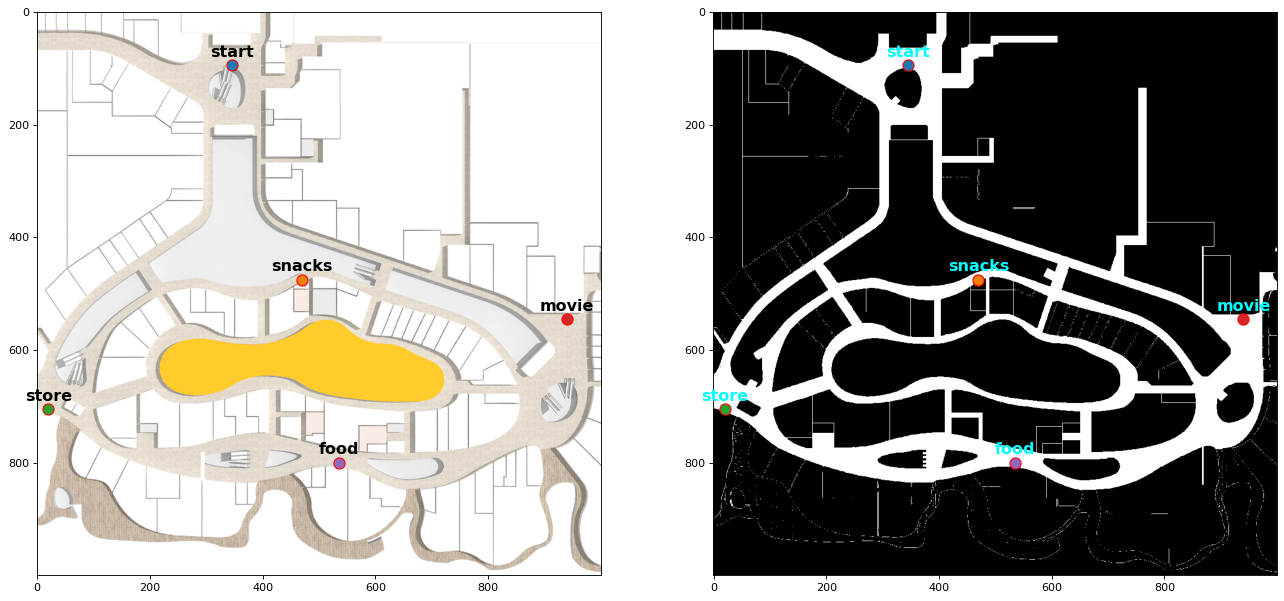

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

In [3]:
def obs_map(grid_map):
    obs = set()     # set for fast research
    # Find obstacles (==0, include boundary)
    obs_array = np.argwhere(grid_map==0)
    for t in obs_array:
        obs.add((t[0], t[1]))     
    return obs
obs = obs_map(grid_map)

In [4]:
# Different kinds of heuristic type design
def heuristic(a, b):
    dx = abs(a[0] - b[0])
    dy = abs(a[1]- b[1])
    estimated_distance = abs(a[0] - b[0]) + abs(a[1] - b[1]) + (1.414 - 2) * min(dx, dy)
    return estimated_distance

# Get the neighbors of the current node
def get_neighbors(node, obs):
    found_collision = False  # whether colliding 
    directions = [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]
    result = []
    delta = math.floor((0.3 / 1.414) / 0.2)

    for direction in directions:
        neighbor = (node[0] + direction[0], node[1] + direction[1])
        for x in range(max(neighbor[0] - delta, 0), min(neighbor[0] + delta + 1, 1000)):
            for y in range(max(neighbor[1] - delta, 0), min(neighbor[1] + delta + 1, 1000)):
                if (x, y) in obs:
                    found_collision = True
                    break  
            if found_collision:
                break
            
        if 0 <= neighbor[0] < grid_map.shape[0] and 0 <= neighbor[1] < grid_map.shape[1]:
            if grid_map[neighbor[0], neighbor[1]] == 255:  # Free space
                result.append(neighbor)
    return result

def a_star_search(start, goal, obs):
    open_set = []
    heapq.heappush(open_set, (0 + heuristic(start, goal), start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    close_set = []

    while not len(open_set) == 0:
        current = heapq.heappop(open_set)[1]
        close_set.append(current)

        if current == goal:
            break

        for next in get_neighbors(current, obs):
            new_cost = cost_so_far[current] + heuristic(current, next)

            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                heapq.heappush(open_set, (new_cost, next))
                came_from[next] = current
    cells = close_set
    return came_from, cost_so_far, cells

def dijkstra(start, goal, obs):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    close_set = []

    while not len(open_set) == 0:
        current = heapq.heappop(open_set)[1]
        close_set.append(current)

        if current == goal:
            break

        for next in get_neighbors(current, obs):
            new_cost = cost_so_far[current] + heuristic(current, next)

            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                heapq.heappush(open_set, (new_cost, next))
                came_from[next] = current
    cells = close_set
    return came_from, cost_so_far, cells

def greedy(start, goal, obs):
    open_set = []
    heapq.heappush(open_set, (heuristic(start, goal), start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    close_set = []

    while not len(open_set) == 0:
        current = heapq.heappop(open_set)[1]
        close_set.append(current)

        if current == goal:
            break

        for next in get_neighbors(current, obs):
            new_cost = heuristic(next, goal)

            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                heapq.heappush(open_set, (new_cost, next))
                came_from[next] = current
    cells = close_set
    return came_from, cost_so_far, cells

def reconstruct_path(came_from, start, goal):
    total_distance = 0
    current = goal
    path = []
    while current != start:
        path.append(current)
        total_distance += heuristic(current, came_from[current])
        current = came_from[current]

    path.append(start)
    path.reverse()
    total_distance = 0.2 * total_distance
    return path, total_distance

def plan_and_plot_path(locations, obs, method, grid_map_img):
    paths = {}
    distances = {}
    visit_order = ['start', 'snacks', 'store', 'movie', 'food']
    colors = ['red', 'blue', 'green', 'yellow', 'magenta'] 

    for start_location in visit_order:
        total_cells = []
        distances[start_location] = {}
        
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_map_img, cmap='gray')
        plot_locations(locations, 'cyan')
        
        color_index = 0  
        
        for end_location in visit_order:
            start_time_part = time.time()
            if start_location == end_location:
                continue  
            
            # Perform a path search based on the selected method
            if method == 'Astar':
                came_from, _, cells = a_star_search(tuple(locations[start_location]), tuple(locations[end_location]), obs)
                total_cells.append(cells)
            elif method == 'Dijkstra':
                came_from, _, cells = dijkstra(tuple(locations[start_location]), tuple(locations[end_location]), obs)
                total_cells.append(cells)
            elif method == 'Greedy':
                came_from, _, cells = greedy(tuple(locations[start_location]), tuple(locations[end_location]), obs)
                total_cells.append(cells)
                
            path, distance = reconstruct_path(came_from, tuple(locations[start_location]), tuple(locations[end_location]))
            paths[f"{start_location} to {end_location}"] = path
            distances[start_location][end_location] = distance
            end_time_part = time.time()

            # output
            print(f"Running time is {end_time_part - start_time_part:.3f}s")
            print(f"Distance from '{start_location}' to '{end_location}': {distance:.3f} meters")
            print(f"The number of visited cells are: {len(cells)}")

            # show the path
            x_coords, y_coords = zip(*path)
            plt.plot(x_coords, y_coords, color=colors[color_index], linewidth=3, 
                     label=f"{start_location} to {end_location} ({distance:.2f}m)")
            color_index = (color_index + 1) % len(colors)  
        
        plt.title(f"Paths from {start_location}")
        plt.axis('off')
        plt.legend()
        plt.show()

        # show the cell figure
        # plt.figure(figsize=(10, 10))
        # plt.imshow(grid_map_img, cmap='gray')
        # plot_locations(locations, 'cyan')
        # all_cells_x = [cell[0] for cells in total_cells for cell in cells]
        # all_cells_y = [cell[1] for cells in total_cells for cell in cells]
        # plt.scatter(all_cells_x, all_cells_y, color='orange', marker='.', s=10)
        # plt.show()

    # 创建 DataFrame
    df = pd.DataFrame(distances, index=visit_order, columns=visit_order)
    df.fillna(0, inplace=True)
    return paths, df
    

Running time is 1.719s
Distance from 'start' to 'snacks': 141.043 meters
The number of visited cells are: 82516
Running time is 2.237s
Distance from 'start' to 'store': 154.418 meters
The number of visited cells are: 98338
Running time is 2.699s
Distance from 'start' to 'movie': 178.411 meters
The number of visited cells are: 121180
Running time is 3.650s
Distance from 'start' to 'food': 218.874 meters
The number of visited cells are: 171942


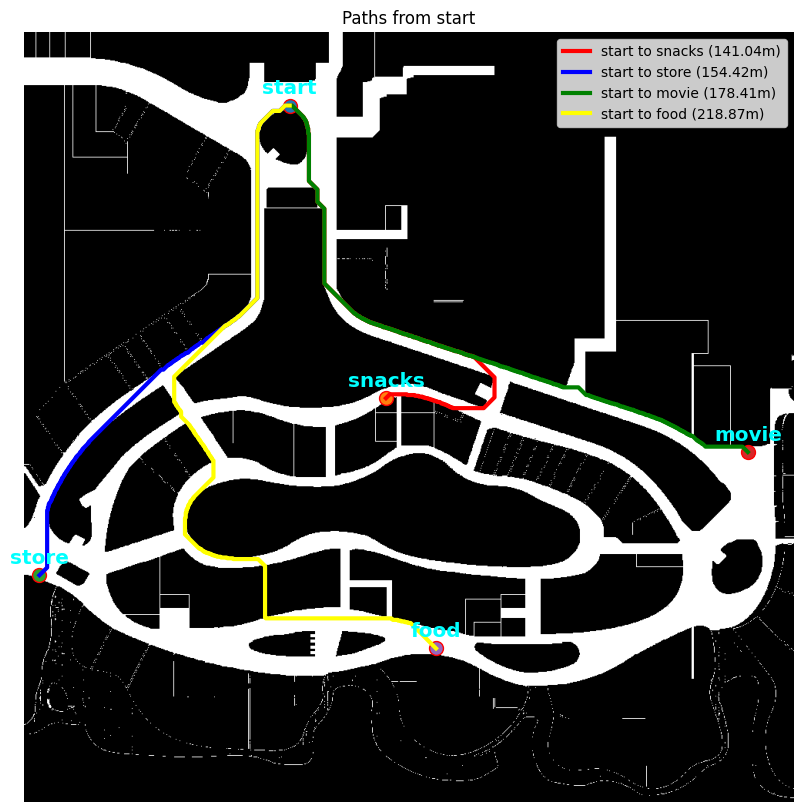

Running time is 3.345s
Distance from 'snacks' to 'start': 141.043 meters
The number of visited cells are: 152638
Running time is 2.208s
Distance from 'snacks' to 'store': 114.318 meters
The number of visited cells are: 99609
Running time is 1.705s
Distance from 'snacks' to 'movie': 106.537 meters
The number of visited cells are: 79533
Running time is 2.956s
Distance from 'snacks' to 'food': 129.691 meters
The number of visited cells are: 134505


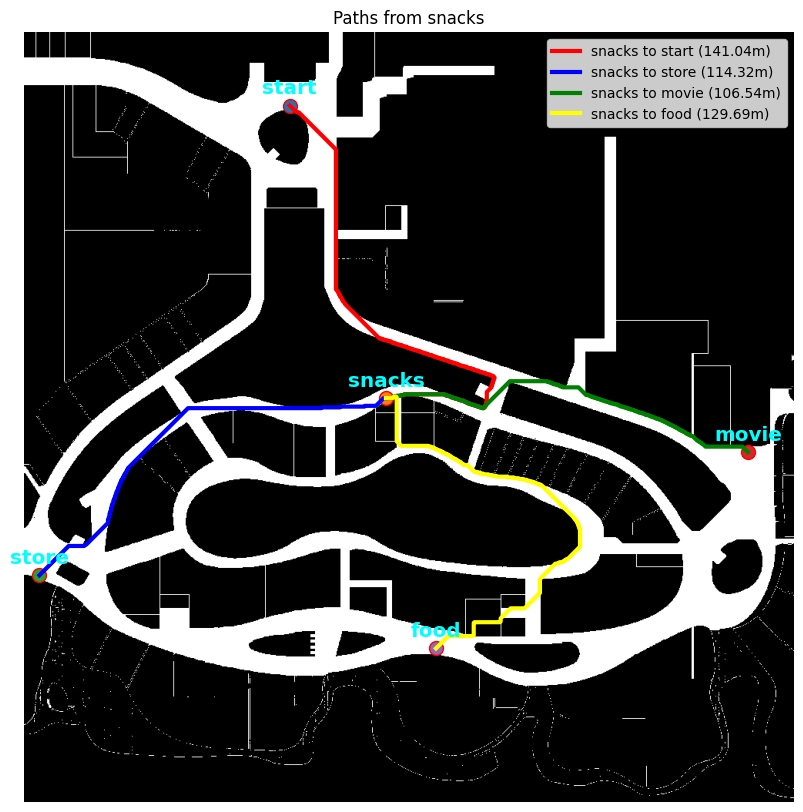

Running time is 2.323s
Distance from 'store' to 'start': 154.418 meters
The number of visited cells are: 107239
Running time is 1.516s
Distance from 'store' to 'snacks': 114.318 meters
The number of visited cells are: 68218
Running time is 3.670s
Distance from 'store' to 'movie': 208.512 meters
The number of visited cells are: 169257
Running time is 1.432s
Distance from 'store' to 'food': 110.866 meters
The number of visited cells are: 66560


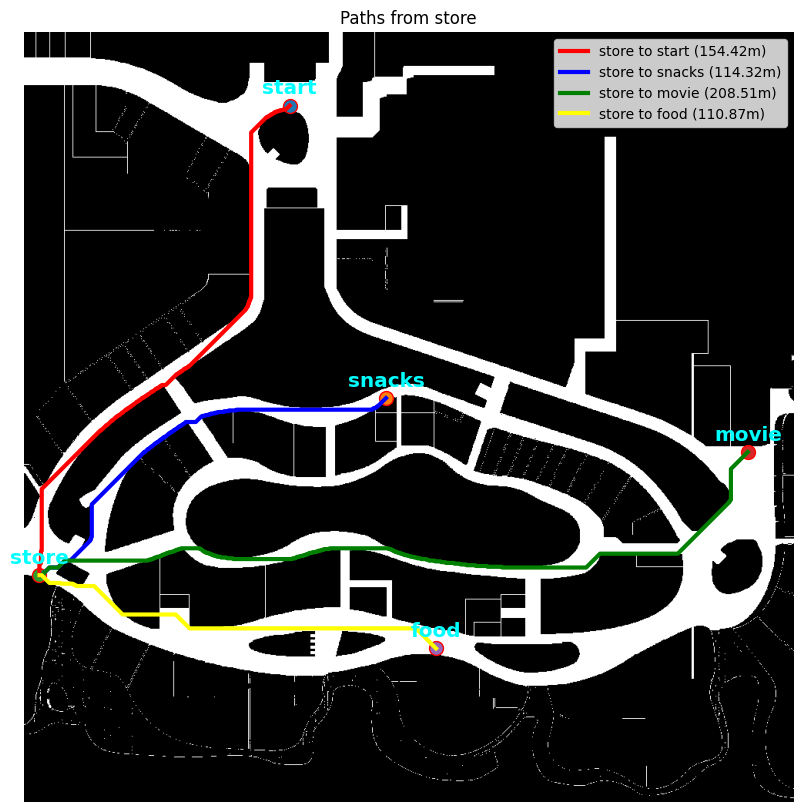

Running time is 3.188s
Distance from 'movie' to 'start': 178.411 meters
The number of visited cells are: 131418
Running time is 1.578s
Distance from 'movie' to 'snacks': 106.537 meters
The number of visited cells are: 67612
Running time is 3.900s
Distance from 'movie' to 'store': 208.512 meters
The number of visited cells are: 165847
Running time is 1.605s
Distance from 'movie' to 'food': 111.373 meters
The number of visited cells are: 70304


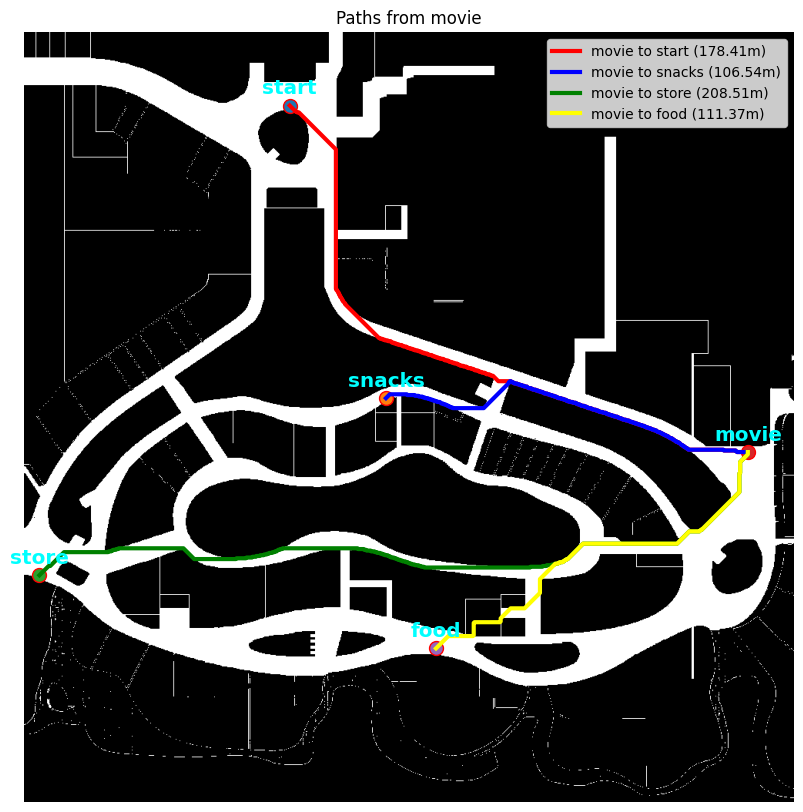

Running time is 3.595s
Distance from 'food' to 'start': 218.874 meters
The number of visited cells are: 156932
Running time is 2.479s
Distance from 'food' to 'snacks': 129.691 meters
The number of visited cells are: 111187
Running time is 2.047s
Distance from 'food' to 'store': 110.866 meters
The number of visited cells are: 87958
Running time is 2.081s
Distance from 'food' to 'movie': 111.373 meters
The number of visited cells are: 88761


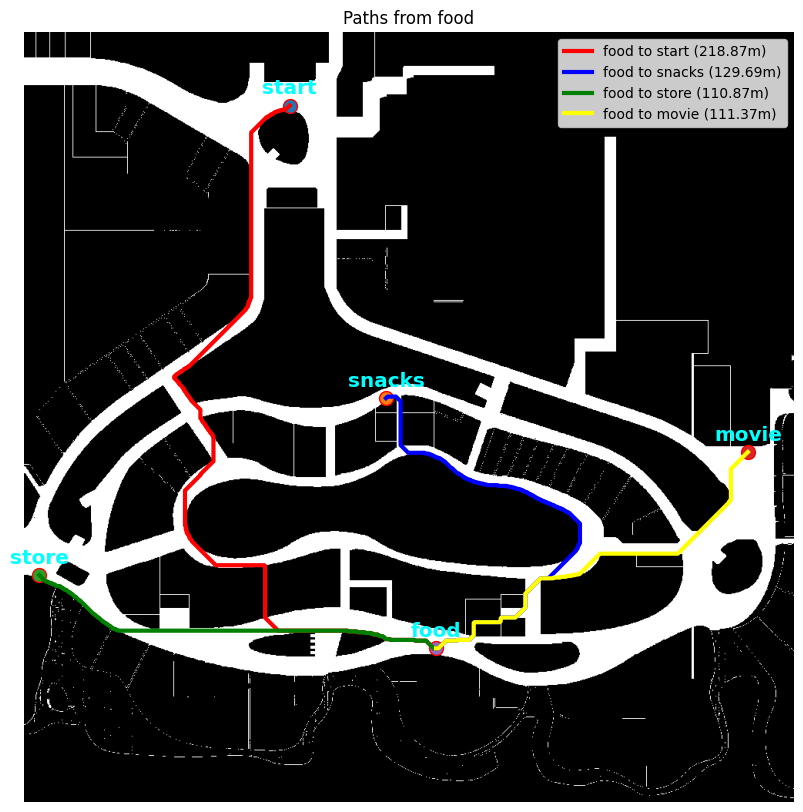

Totoal running time is 50.608s
           start    snacks     store     movie      food
start     0.0000  141.0428  154.4184  178.4108  218.8744
snacks  141.0428    0.0000  114.3180  106.5372  129.6912
store   154.4184  114.3180    0.0000  208.5116  110.8660
movie   178.4108  106.5372  208.5116    0.0000  111.3728
food    218.8744  129.6912  110.8660  111.3728    0.0000


In [5]:
start_time_part = time.time()
path, df = plan_and_plot_path(locations, obs, 'Astar',grid_map_img)
end_time_part = time.time()
print(f"Totoal running time is {end_time_part - start_time_part:.3f}s")
print(df)

Running time is 1.840s
Distance from 'start' to 'snacks': 141.043 meters
The number of visited cells are: 82516
Running time is 2.192s
Distance from 'start' to 'store': 154.418 meters
The number of visited cells are: 98338
Running time is 2.747s
Distance from 'start' to 'movie': 178.411 meters
The number of visited cells are: 121180
Running time is 3.931s
Distance from 'start' to 'food': 218.874 meters
The number of visited cells are: 171942


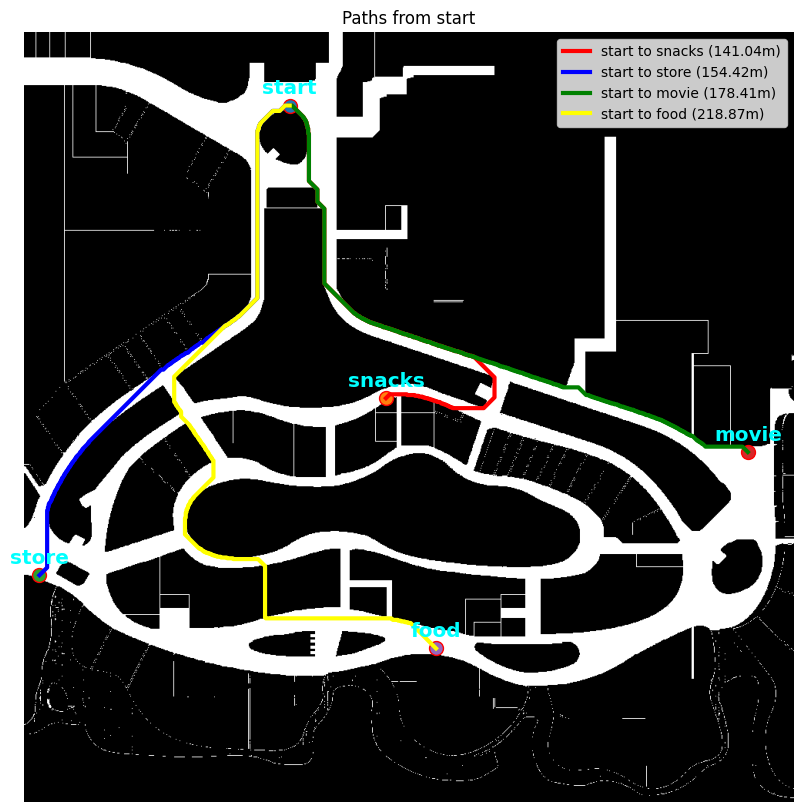

Running time is 3.571s
Distance from 'snacks' to 'start': 141.043 meters
The number of visited cells are: 152638
Running time is 2.189s
Distance from 'snacks' to 'store': 114.318 meters
The number of visited cells are: 99609
Running time is 1.705s
Distance from 'snacks' to 'movie': 106.537 meters
The number of visited cells are: 79533
Running time is 3.024s
Distance from 'snacks' to 'food': 129.691 meters
The number of visited cells are: 134505


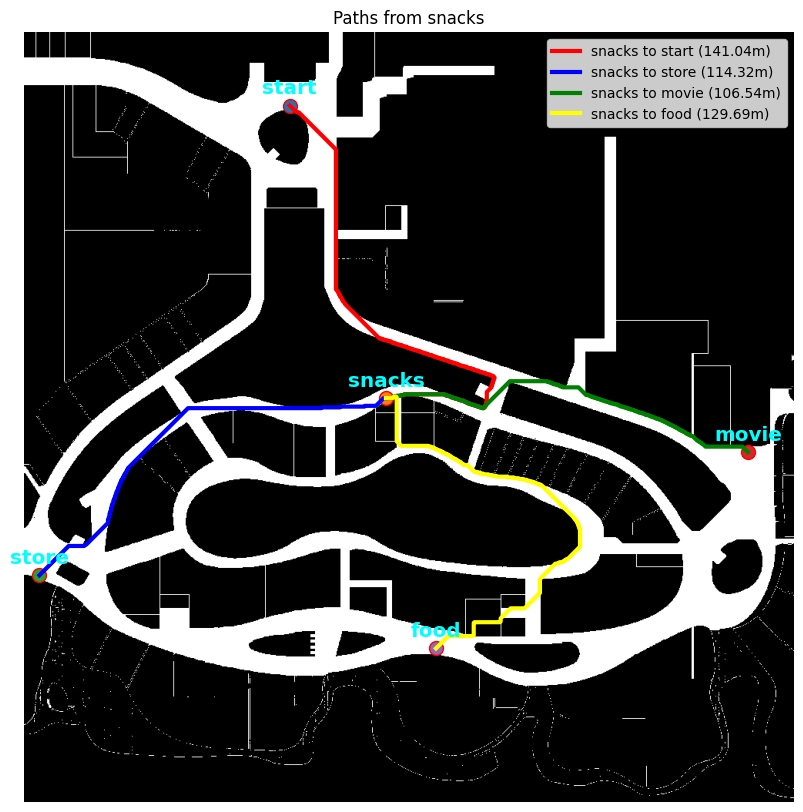

Running time is 2.306s
Distance from 'store' to 'start': 154.418 meters
The number of visited cells are: 107239
Running time is 1.471s
Distance from 'store' to 'snacks': 114.318 meters
The number of visited cells are: 68218
Running time is 3.602s
Distance from 'store' to 'movie': 208.512 meters
The number of visited cells are: 169257
Running time is 1.467s
Distance from 'store' to 'food': 110.866 meters
The number of visited cells are: 66560


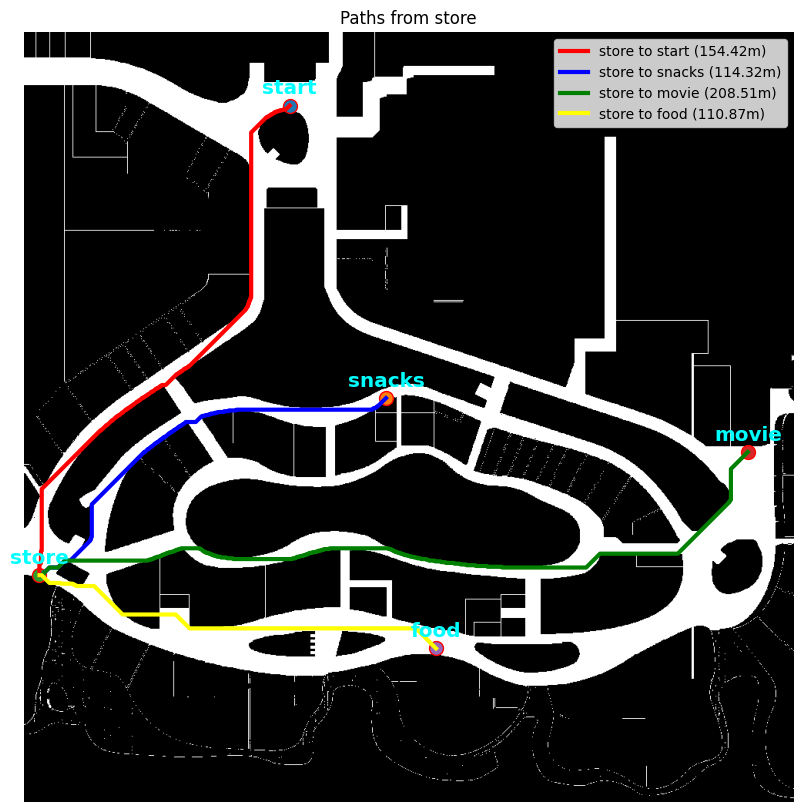

Running time is 3.000s
Distance from 'movie' to 'start': 178.411 meters
The number of visited cells are: 131418
Running time is 1.545s
Distance from 'movie' to 'snacks': 106.537 meters
The number of visited cells are: 67612
Running time is 3.852s
Distance from 'movie' to 'store': 208.512 meters
The number of visited cells are: 165847
Running time is 1.593s
Distance from 'movie' to 'food': 111.373 meters
The number of visited cells are: 70304


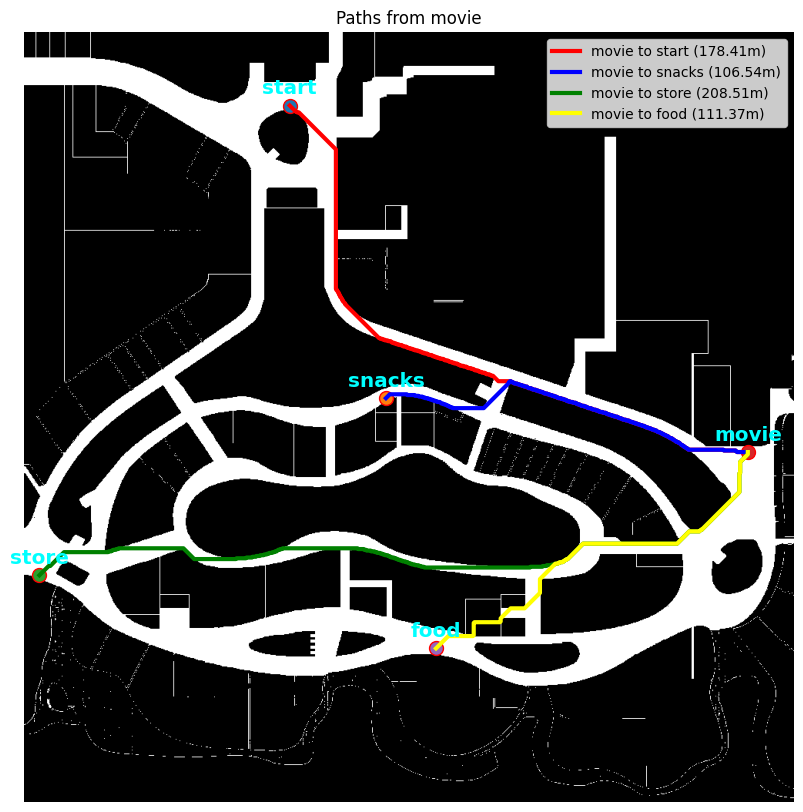

Running time is 3.615s
Distance from 'food' to 'start': 218.874 meters
The number of visited cells are: 156932
Running time is 2.552s
Distance from 'food' to 'snacks': 129.691 meters
The number of visited cells are: 111187
Running time is 2.096s
Distance from 'food' to 'store': 110.866 meters
The number of visited cells are: 87958
Running time is 2.115s
Distance from 'food' to 'movie': 111.373 meters
The number of visited cells are: 88761


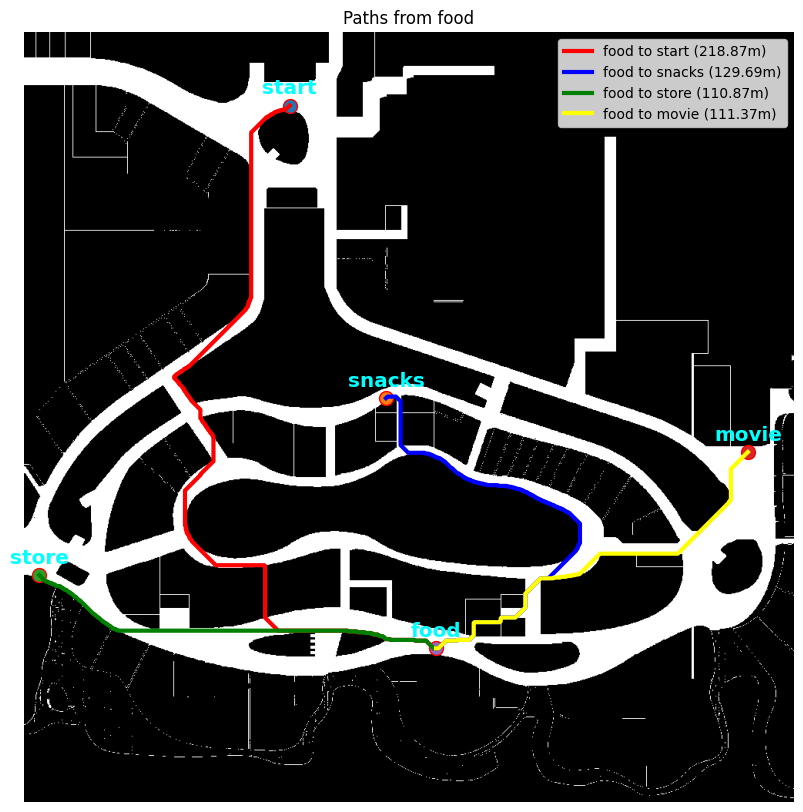

Totoal running time is 51.110s
           start    snacks     store     movie      food
start     0.0000  141.0428  154.4184  178.4108  218.8744
snacks  141.0428    0.0000  114.3180  106.5372  129.6912
store   154.4184  114.3180    0.0000  208.5116  110.8660
movie   178.4108  106.5372  208.5116    0.0000  111.3728
food    218.8744  129.6912  110.8660  111.3728    0.0000


In [6]:
start_time_part = time.time()
path, df = plan_and_plot_path(locations, obs, 'Dijkstra',grid_map_img)
end_time_part = time.time()
print(f"Totoal running time is {end_time_part - start_time_part:.3f}s")
print(df)

Running time is 0.114s
Distance from 'start' to 'snacks': 145.644 meters
The number of visited cells are: 5284
Running time is 0.016s
Distance from 'start' to 'store': 163.312 meters
The number of visited cells are: 715
Running time is 0.054s
Distance from 'start' to 'movie': 211.300 meters
The number of visited cells are: 2558
Running time is 0.088s
Distance from 'start' to 'food': 236.472 meters
The number of visited cells are: 3483


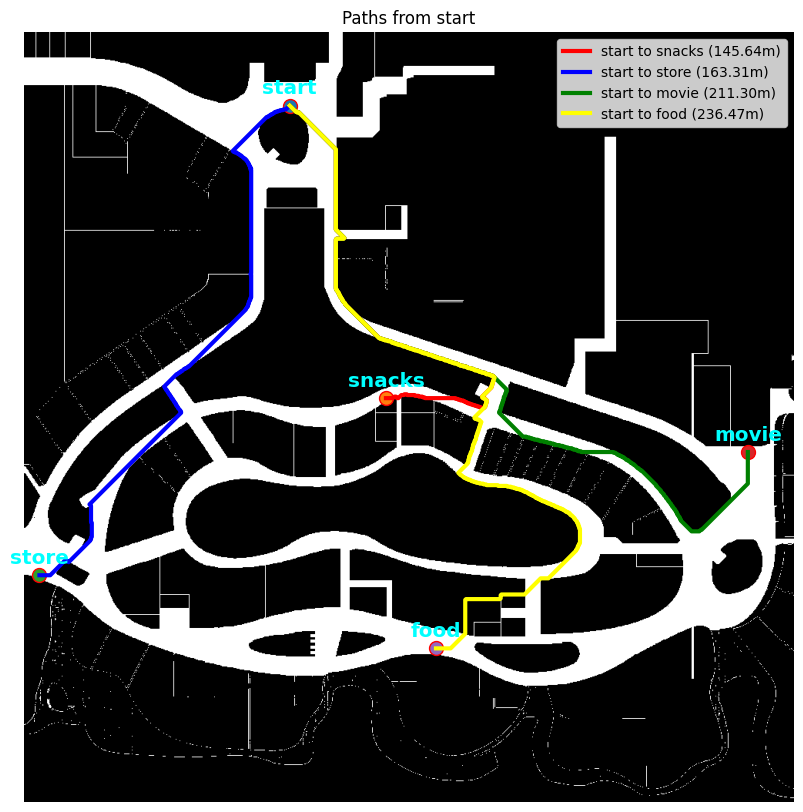

Running time is 0.132s
Distance from 'snacks' to 'start': 161.012 meters
The number of visited cells are: 5855
Running time is 0.011s
Distance from 'snacks' to 'store': 122.257 meters
The number of visited cells are: 528
Running time is 0.019s
Distance from 'snacks' to 'movie': 141.597 meters
The number of visited cells are: 938
Running time is 0.036s
Distance from 'snacks' to 'food': 135.857 meters
The number of visited cells are: 1674


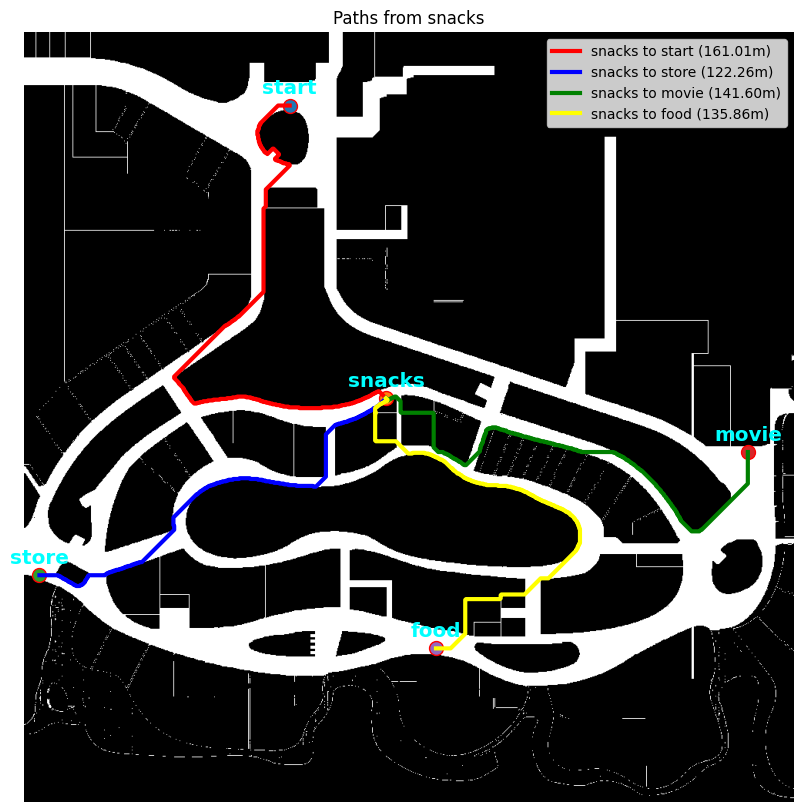

Running time is 0.019s
Distance from 'store' to 'start': 173.852 meters
The number of visited cells are: 913
Running time is 0.012s
Distance from 'store' to 'snacks': 120.292 meters
The number of visited cells are: 537
Running time is 0.113s
Distance from 'store' to 'movie': 254.822 meters
The number of visited cells are: 1817
Running time is 0.012s
Distance from 'store' to 'food': 118.372 meters
The number of visited cells are: 574


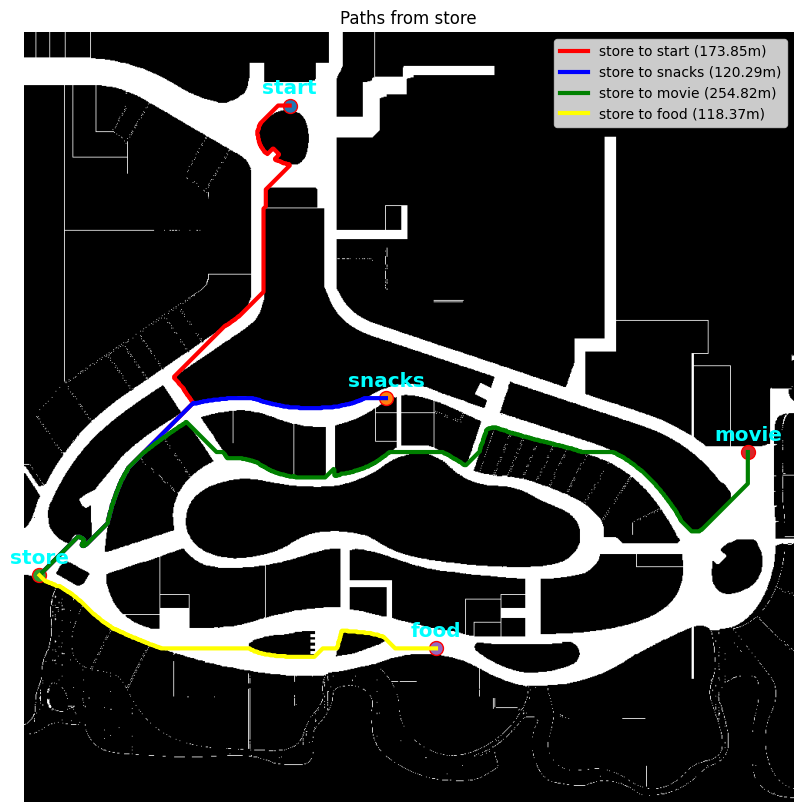

Running time is 0.032s
Distance from 'movie' to 'start': 195.649 meters
The number of visited cells are: 1494
Running time is 0.015s
Distance from 'movie' to 'snacks': 108.751 meters
The number of visited cells are: 697
Running time is 0.022s
Distance from 'movie' to 'store': 240.763 meters
The number of visited cells are: 1078
Running time is 0.042s
Distance from 'movie' to 'food': 204.340 meters
The number of visited cells are: 1963


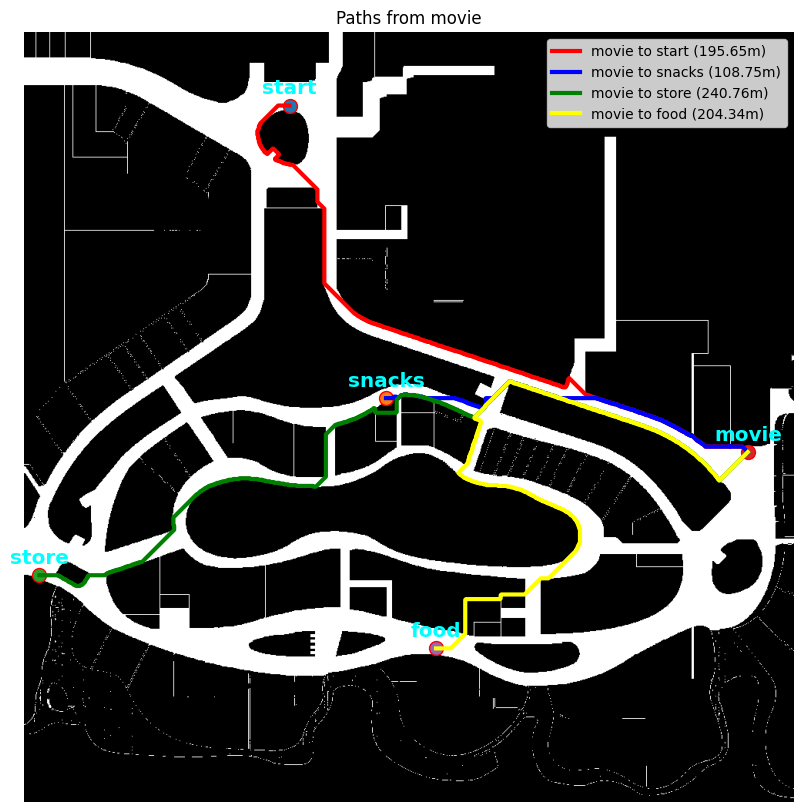

Running time is 0.218s
Distance from 'food' to 'start': 284.780 meters
The number of visited cells are: 10331
Running time is 0.318s
Distance from 'food' to 'snacks': 187.645 meters
The number of visited cells are: 14939
Running time is 0.021s
Distance from 'food' to 'store': 131.442 meters
The number of visited cells are: 1039
Running time is 0.018s
Distance from 'food' to 'movie': 118.871 meters
The number of visited cells are: 968


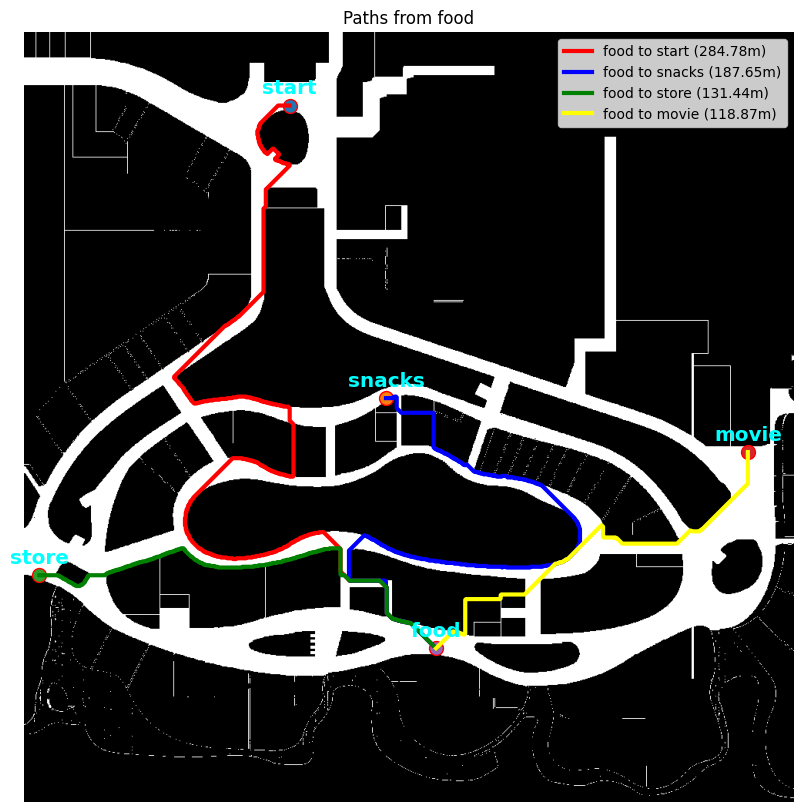

Totoal running time is 1.953s
           start    snacks     store     movie      food
start     0.0000  161.0120  173.8524  195.6488  284.7796
snacks  145.6440    0.0000  120.2924  108.7512  187.6452
store   163.3124  122.2568    0.0000  240.7632  131.4416
movie   211.2996  141.5968  254.8216    0.0000  118.8708
food    236.4716  135.8568  118.3716  204.3404    0.0000


In [7]:
start_time_part = time.time()
path, df = plan_and_plot_path(locations, obs, 'Greedy',grid_map_img)
end_time_part = time.time()
print(f"Totoal running time is {end_time_part - start_time_part:.3f}s")
print(df)

## Task 2

### Direct traversal method

In [8]:
import itertools
import numpy
import matplotlib.pyplot as plt
import pandas as pd

def plan_shortest_path(locations, df):
    visit_order = ['snacks', 'movie', 'food', 'store']

    shortest_distance = float('inf')
    shortest_path = None

    # Traverse all possible path combinations
    for path in itertools.permutations(visit_order):
        total_distance = 0
        total_distance += df.loc['start', path[0]]  # start from the start point 
        for i in range(len(path) - 1):
            total_distance += df.loc[path[i], path[i+1]]  
        total_distance += df.loc[path[-1], 'start']  # end should back to start

        # renew the shortest path
        if total_distance < shortest_distance:
            shortest_distance = total_distance
            shortest_path = path

    return shortest_path, shortest_distance

start_time = time.time()
# plan the shortest path
shortest_path, shortest_distance = plan_shortest_path(locations, df)
# shortest_path, shortest_distance = plan_shortest_path(locations, distances)
end_time = time.time()

shortest_path = ('start',) + shortest_path + ('start',)
print("Shortest path:", shortest_path)
print(f"Shortest distance:{shortest_distance:.3f}m")
print(f"running time:{end_time - start_time:.3f}s")

Shortest path: ('start', 'snacks', 'movie', 'food', 'store', 'start')
Shortest distance:670.318m
running time:0.001s


### PSO method

In [9]:
import random

class Particle:
    def __init__(self, sequence):
        self.sequence = sequence
        self.fitness = 0

def calculate_distance(sequence, distance_matrix):
    total_distance = 0
    for i in range(len(sequence) - 1):
        current_location = sequence[i] - 1  
        next_location = sequence[i + 1] - 1  
        total_distance += distance_matrix[current_location][next_location]
    return total_distance


def initialize_population(population_size, num_locations):
    population = []
    for _ in range(population_size):
        sequence = [2, 3, 4, 5] 
        random.shuffle(sequence)    
        # Add 1 to the beginning and end of the sequence
        sequence.insert(0, 1)  
        sequence.append(1)  
        particle = Particle(sequence)
        population.append(particle)
    return population

def update_particle_velocity(particle, global_best_sequence, c1, c2):
    new_sequence = [1] + global_best_sequence[1:-1] + [1]
    random.shuffle(new_sequence[1:-1])  
    particle.sequence = new_sequence  # renew particle sequence

def update_global_best_particle(particles):
    global_best_particle = min(particles, key=lambda x: x.fitness)
    return global_best_particle.sequence

def pso_algorithm(df_distance, population_size=50, max_iterations=100, c1=2, c2=2):
    num_locations = len(df_distance)
    particles = initialize_population(population_size, num_locations)
    global_best_sequence = None
    global_best_fitness = float('inf')

    for _ in range(max_iterations):
        for particle in particles:
            particle.fitness = calculate_distance(particle.sequence, df_distance.values)
            global_best_fitness = min(global_best_fitness, particle.fitness)
            if particle.fitness == global_best_fitness:
                global_best_sequence = particle.sequence
        
        for particle in particles:
            update_particle_velocity(particle, global_best_sequence, c1, c2)
        
        global_best_sequence = update_global_best_particle(particles)

    return global_best_sequence, global_best_fitness


# main function
start_time = time.time()
best_sequence, best_fitness = pso_algorithm(df)
end_time = time.time()
best_sequence = [df.columns[idx - 1] for idx in best_sequence]
# global_best_sequence, global_best_fitness = pso_algorithm(df)
print("Best sequence:", best_sequence)
print(f"Best fitness (total distance):{best_fitness:.3f}m")
print(f"running time:{end_time - start_time:.3f}s")

Best sequence: ['start', 'snacks', 'movie', 'food', 'store', 'start']
Best fitness (total distance):670.318m
running time:0.014s
